# First model
The goal of this model is to establish the pattern of importing image data and building a simple model.

Model performance is not a priority, that comes later.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy import misc
import matplotlib.pyplot as plt
from skimage.transform import resize

## Get data

In [2]:
IMAGE_PATH = 'data/images/capture/'

data = pd.DataFrame.from_csv('data/labels/rugby_image_labels_2.csv')

data.head()

,y
file_name,
1491257473.62.jpg,327.0
1491257474.29.jpg,336.0
1491257474.83.jpg,367.0
1491257475.45.jpg,392.0
1491257476.09.jpg,401.0


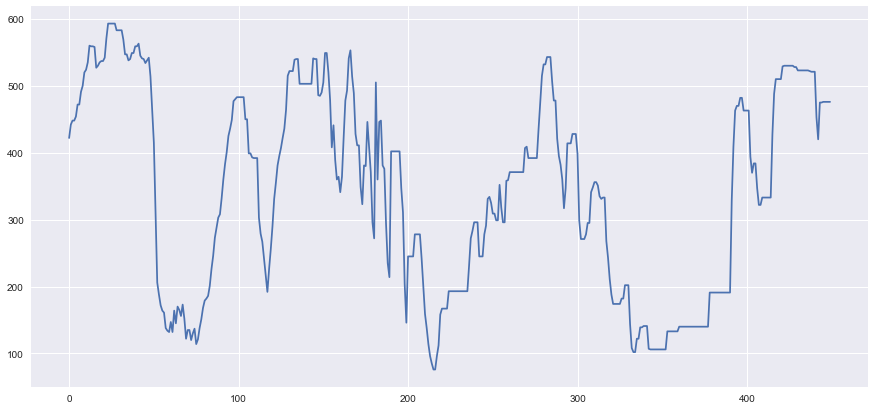

In [53]:
import seaborn
plt.figure(figsize=(15,7))
plt.plot(data.y.tolist()[150:600])

In [38]:
test_img = misc.imread(IMAGE_PATH + data.iloc[90].name,flatten=True)
test_img2 = misc.imread(IMAGE_PATH + data.iloc[91].name,flatten=True)
test_img.shape

(480, 640)

In [39]:
import matplotlib._cm

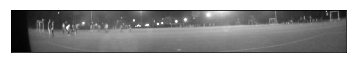

In [40]:
plt.imshow(test_img[240:320], cmap='gray')
plt.tick_params(axis='both', 
                which='both', 
                bottom='off', 
                top='off', 
                labelbottom='off', 
                right='off', 
                left='off', 
                labelleft='off')
plt.show()

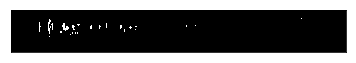

In [41]:

delta = test_img[240:320] - test_img2[240:320]
delta = delta > 20

plt.imshow(delta, cmap='gray')
plt.tick_params(axis='both', 
                which='both', 
                bottom='off', 
                top='off', 
                labelbottom='off', 
                right='off', 
                left='off', 
                labelleft='off')
plt.show()

## Define image preprocessing (resizing)

In [416]:
def my_image_resize(img):
    return resize(image=(img[240:320]/(255/2))-1, output_shape=(20,80))

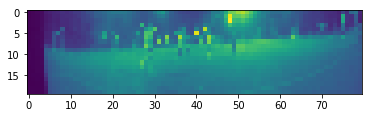

In [417]:
plt.imshow(my_image_resize(test_img))
plt.show()

In [418]:
my_image_resize(test_img).shape

(20, 80)

In [419]:
get_rows = 500
# get sizes of image data 
m = data.shape[0]
image_size = [20, 80]#test_img.shape
# total size of numpy volume
data_size = [get_rows, *image_size]

## Fetch images an calculate delta images

In [447]:
# fill numpy volume with image data
data_np = np.zeros(data_size)
count = 0
prev_img = None
for i, v in data[:get_rows].iterrows():

    if np.isnan(v['y']) == False:
        
        if not(count % 100):
            print(count)

        new_img = my_image_resize(misc.imread(IMAGE_PATH + i, flatten=True))
        if prev_img is not None:
            delta_img = np.clip((prev_img - new_img),a_min=0, a_max=1)
            data_np[count,:,:] =  delta_img
        prev_img = new_img
        count += 1

0
100
200
300
400


In [448]:
data_np[9]

array([[ 0.        ,  0.00312155,  0.00385882, ...,  0.        ,
         0.        ,  0.00278232],
       [ 0.        ,  0.        ,  0.00287648, ...,  0.        ,
         0.        ,  0.00029999],
       [ 0.00408234,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.00134119,  0.00302744, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00061959,  0.        ,  0.        , ...,  0.        ,
         0.0078353 ,  0.00704707],
       [ 0.        ,  0.00588235,  0.00304903, ...,  0.00141764,
         0.00010982,  0.        ]])

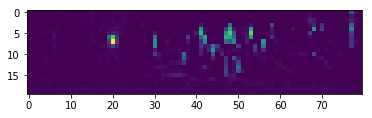

In [449]:
plt.imshow(data_np[20])
plt.show()

In [450]:
data_np.shape

(500, 20, 80)

In [328]:
# np.save('data/numpy_images/d1.npy', data_np)

## Define and train network

In [329]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from keras import optimizers

In [330]:
from sklearn.model_selection import train_test_split

In [458]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(20, 80, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

In [459]:
model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [453]:
X = data_np.reshape([*data_np.shape,1])
y = data.dropna()[:get_rows]/640

# skip first image as it had no previous image an therefore delta was not calculated
X = X[1:]
y = y[1:]

In [503]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [463]:
model.fit(x_train, y_train,
          batch_size=50,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 399 samples, validate on 100 samples
Epoch 1/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0187 - val_loss: 0.0201
Epoch 2/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0203 - val_loss: 0.0206
Epoch 3/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0166 - val_loss: 0.0168
Epoch 4/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0166 - val_loss: 0.0139
Epoch 5/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0194 - val_loss: 0.0187
Epoch 6/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0191 - val_loss: 0.0170
Epoch 7/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0131 - val_loss: 0.0151
Epoch 8/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0121 - val_loss: 0.0201
Epoch 9/10
399/399 [==============================] - 2s 5ms/step - loss: 0.0157 - val_loss: 0.0138
Epoch 10/10
399/399 [==============================] -

## Show predictions

In [486]:
preds = model.predict(x_train[:10])

0.175629 0
(20, 80)
14


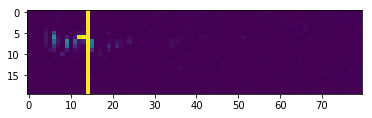

0.463906 1
(20, 80)
37


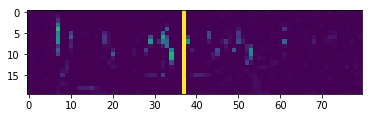

0.238894 2
(20, 80)
19


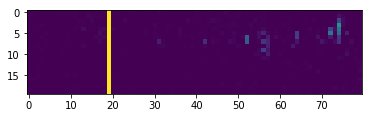

0.264636 3
(20, 80)
21


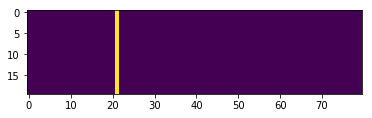

0.318422 4
(20, 80)
25


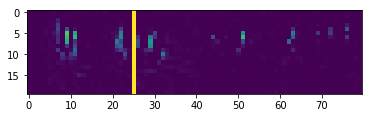

0.302033 5
(20, 80)
24


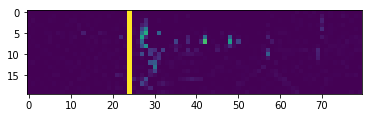

0.484609 6
(20, 80)
38


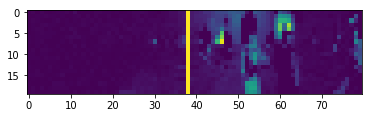

0.402594 7
(20, 80)
32


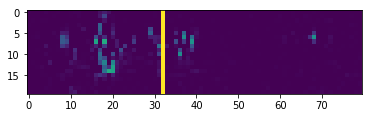

0.376224 8
(20, 80)
30


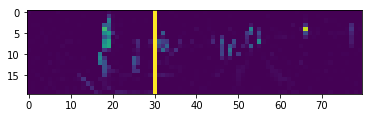

0.696044 9
(20, 80)
55


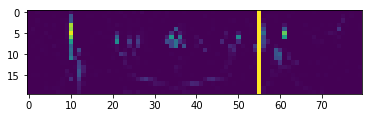

In [508]:
for i,(p,) in enumerate(preds):
    print(p,i )
    temp_img = np.copy(x_train[i].reshape(x_train[3].shape[:-1]))
    pred_col = int(temp_img.shape[1]*p)
    print(temp_img.shape)
    temp_img[:, pred_col] = 1
    print(pred_col)
    plt.imshow(temp_img)
    plt.show()